In [2]:
import pandas as pd
import json
import seaborn as sns
from matplotlib import pyplot as plt
import glob
import math
import numpy as np
from adjustText import adjust_text
from collections import defaultdict
import pickle as pkl

### Multiclass overall performance
Let's look at F1 in the multiclass classification task

In [3]:
sns.set_style('whitegrid')

In [32]:
audio = pd.read_json('../logs/aggregates/audio_performance.jsonl', lines=True)
text = pd.read_json('../logs/aggregates/text_performance.jsonl', lines=True)
ensemble = pd.read_json('../logs/aggregates/ensemble_performance_max.jsonl', lines=True)
dummy = pd.read_json('../logs/aggregates/dummy_baseline.jsonl', lines=True)

In [33]:
audio = pd.concat([audio, dummy], ignore_index=True)
text = pd.concat([text, dummy], ignore_index=True)
audio = pd.concat([audio, ensemble], ignore_index=True)
text = pd.concat([text, ensemble], ignore_index=True)

In [34]:
def _plot_multiclass_metrics(data, metric, level, figsize, modality, target_class):
    fig, ax = plt.subplots(figsize=figsize)
    if target_class == 'multiclass':
            df = data[(data['score_type'] == metric) & \
                      (data['level']==level) & \
                      (data['binary']==0)]
    else:
        df = data[(data['score_type'] == metric) & \
                  (data['level']==level) & \
                  (data['binary']==1) &
                  (data['target_class']==target_class)]
    df['model_name'] = df.model_name.apply(lambda x: x.split(r'_lr')[0])
    df['model_name'] = np.where(df['is_baseline']==1 & ~df['model_name'].str.contains('baseline_'), 
                                'baseline_' + df['model_name'], 
                                df['model_name'])
    df = df.sort_values(by=['split', 'value'])
    sns.scatterplot(data=df, y='model_name', x='value', hue='split', 
                    palette=['grey', sns.color_palette()[1], sns.color_palette()[3]], 
                    hue_order=['train', 'val', 'test'], marker='s', ax=ax)
    plt.legend(title=None)
    plt.title(f'{modality} models, {target_class}')
    sns.lineplot(data=df,  
                 x='value', y='model_name', hue='model_name',
                 legend=False, 
                 palette=['grey']*df.model_name.nunique(), 
                 alpha=.4, ax=ax)
    # color labels by baseline or transformer
    label_cols = ["grey" if "baseline" in model_n else "sienna" for model_n in df["model_name"].unique()]
    # update ensemble colors
    label_cols = ["steelblue" if "ensemble" in model_n else label_cols[i] for i, model_n in enumerate(df["model_name"].unique())]
    [t.set_color(label_cols[i]) for i, t in enumerate(ax.yaxis.get_ticklabels())]
    plt.xlim(0,1)
    plt.xlabel(f'{metric}')
    plt.ylabel('')
    plt.savefig(f"../figs/model_name_{metric}_{target_class}_{modality}.png", bbox_inches="tight", dpi=300)
    plt.show()

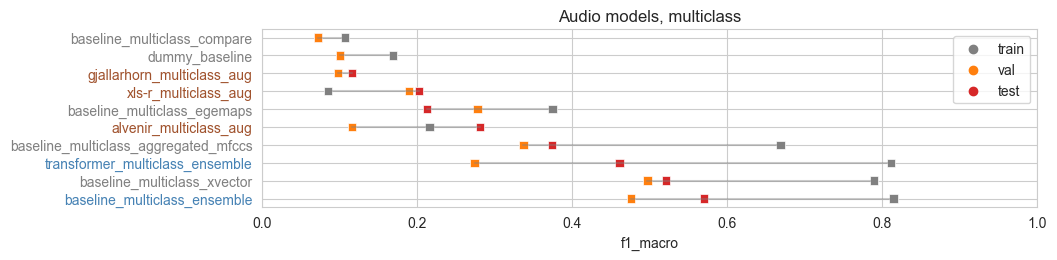

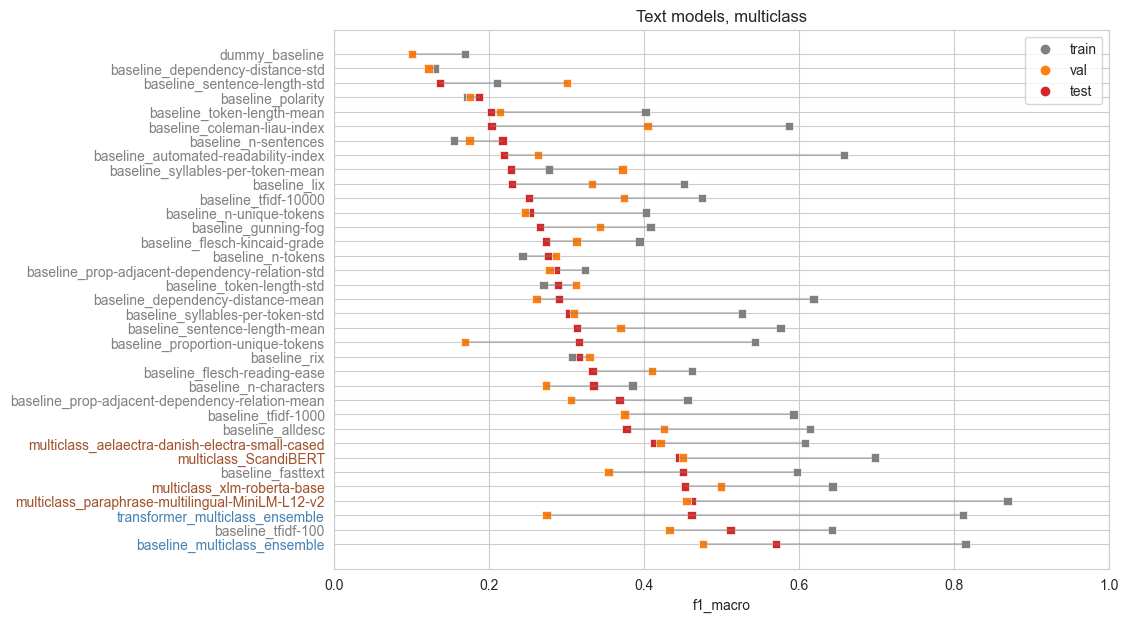

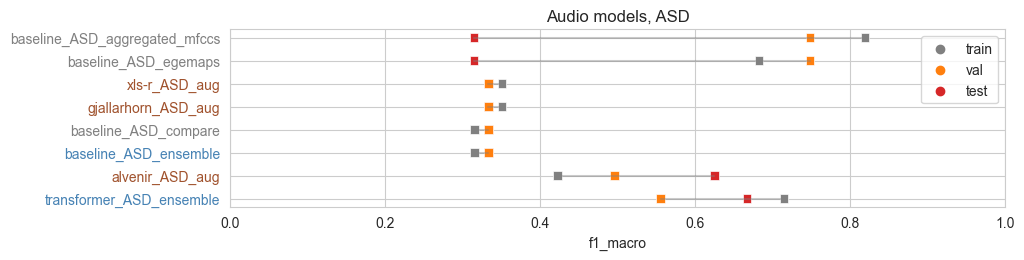

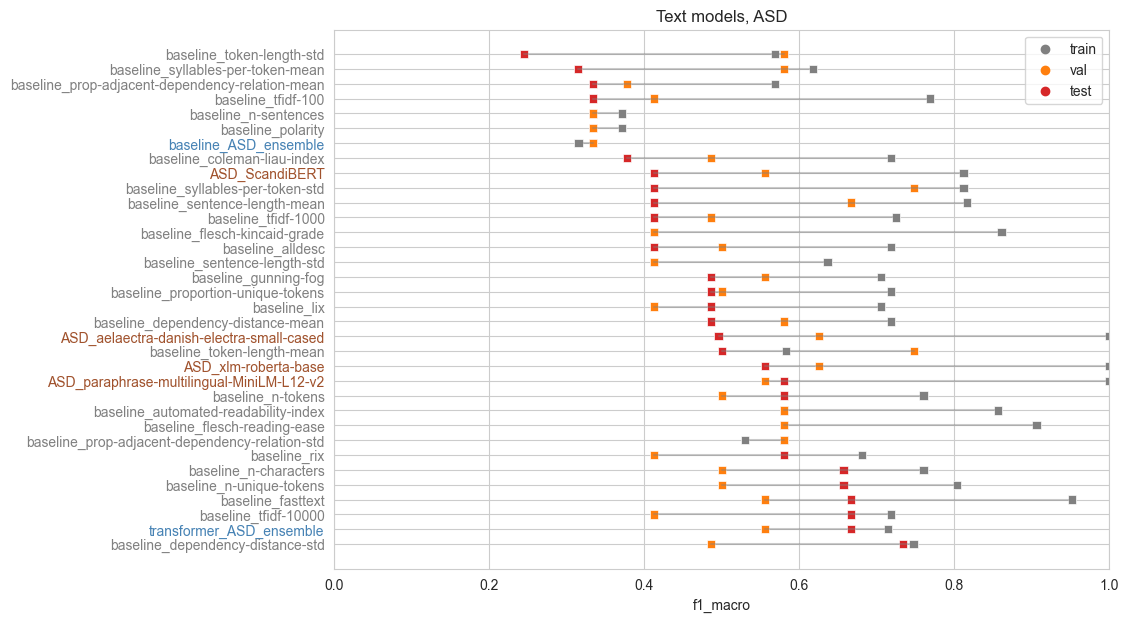

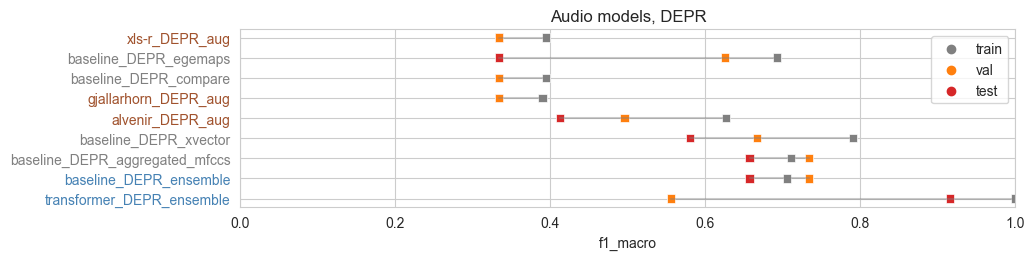

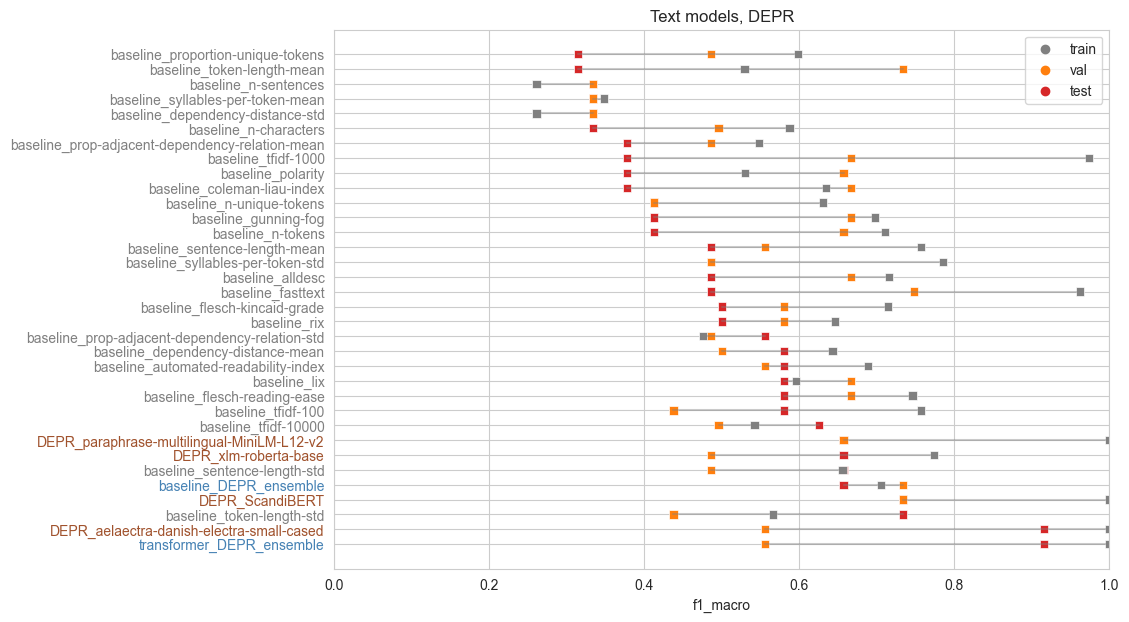

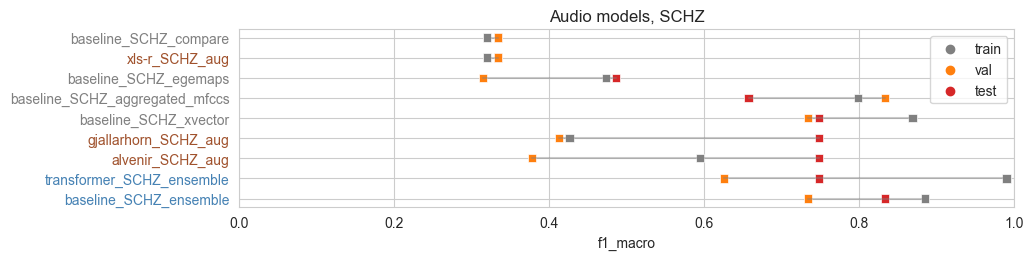

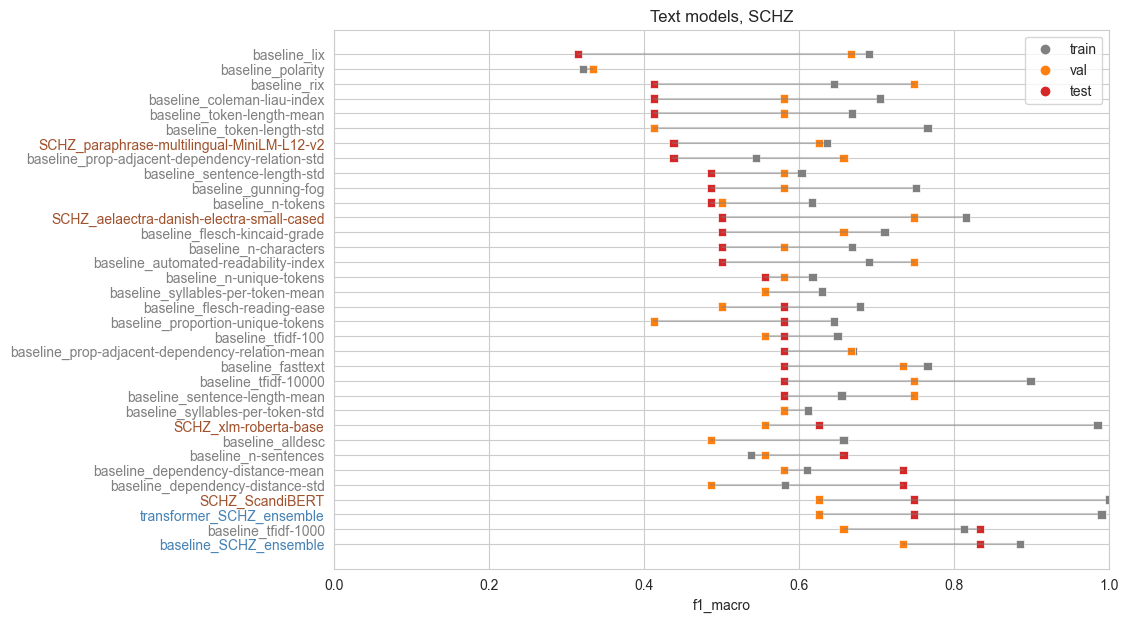

In [35]:
import warnings
warnings.filterwarnings('ignore')
for target_class in ['multiclass', 'ASD', 'DEPR', 'SCHZ']:
    _plot_multiclass_metrics(audio, 'f1_macro', 'id', (10,2.3), 'Audio', target_class)
    _plot_multiclass_metrics(text, 'f1_macro', 'id', (10,7), 'Text', target_class)

Let's visualize balance between precision and recall

In [36]:
def _precision_recall(data, target_class):
    df = data[(data['split']=='test') & \
              (data['target_class']==target_class) & \
              (data['level']=='id') & \
              (data['class']=='overall')]
    #print(df)
    df['model_name'] = df.model_name.apply(lambda x: x.split(r'_lr')[0])
    df = df.pivot(columns='score_type', values='value',
                  index= ['model_name', 'is_baseline']).reset_index()
    fig, ax = plt.subplots(figsize=(10,7))
    sns.scatterplot(data=df, x=f'precision_macro', y=f'recall_macro')
    sns.lineplot(x=[.0,.6], y=[.0,.6], color='grey', alpha=.7, linestyle='--')
    texts = []
    for i in range(df.shape[0]):
        texts.append(plt.text(x=df[f'precision_macro'][i]+.002, 
                 y=df[f'recall_macro'][i]+.002, 
                 s=df['model_name'][i]))
    adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1,1), expand_text=(1,1))
    plt.xlabel(f'test precision')
    plt.ylabel(f'test recall')
    plt.show()

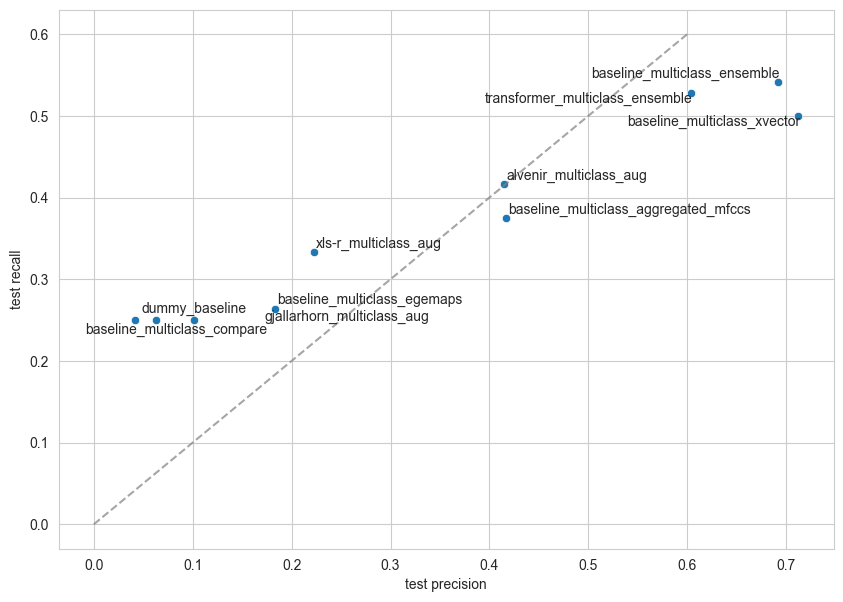

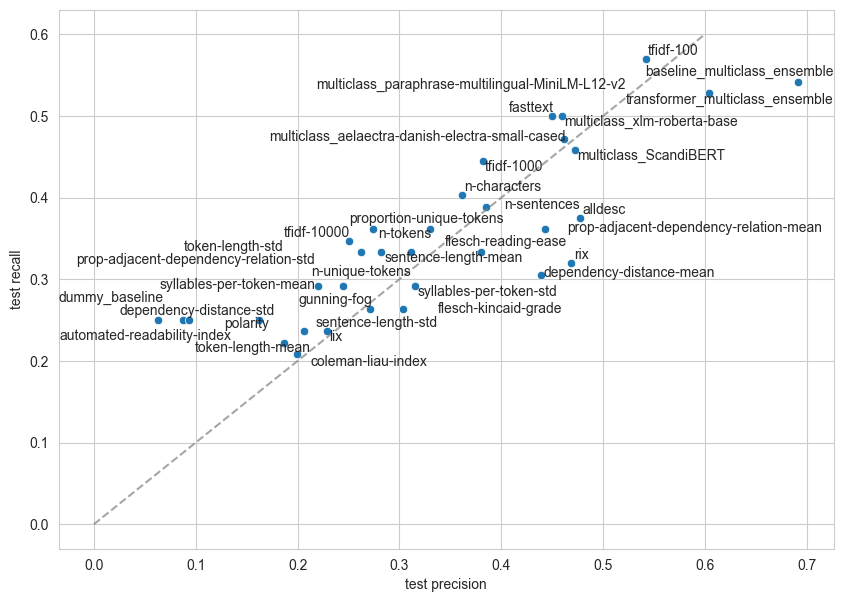

In [37]:
_precision_recall(audio, 'multiclass')
_precision_recall(text, 'multiclass')

### Now let's look at performance of the multiclass model for each class

In [38]:
def _swarmperf(data, modality):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,8))
    for ib in [1,0]:
        is_baseline = 'baselines' if ib == 1 else 'transformers'
        for i, metric in enumerate(['f1', 'precision', 'recall']):
            df = data[(data['score_type']==metric) & \
                      (data['split']=='test') & \
                      (data['target_class']=='multiclass') & \
                      (data['class']!='overall') & \
                      (data['is_baseline']==ib) & \
                      (data['level']=='id') & \
                      ~(data['model_name'].str.contains('ensemble')) & \
                      ~(data['model_name'].str.contains('dummy'))
                     ]
            sns.swarmplot(data=df, x='class', y='value', ax=ax[ib,i])
            ax[ib,i].set_xlabel('')
            ax[ib,i].set_ylabel(f'{metric}')
            ax[ib,i].set_ylim(-0.05,1)
            
            ax[ib,1].set_title(f'{modality} {is_baseline}')
    plt.show()

Ok, now let's look at F1 category by category, just starting from the overall distribution

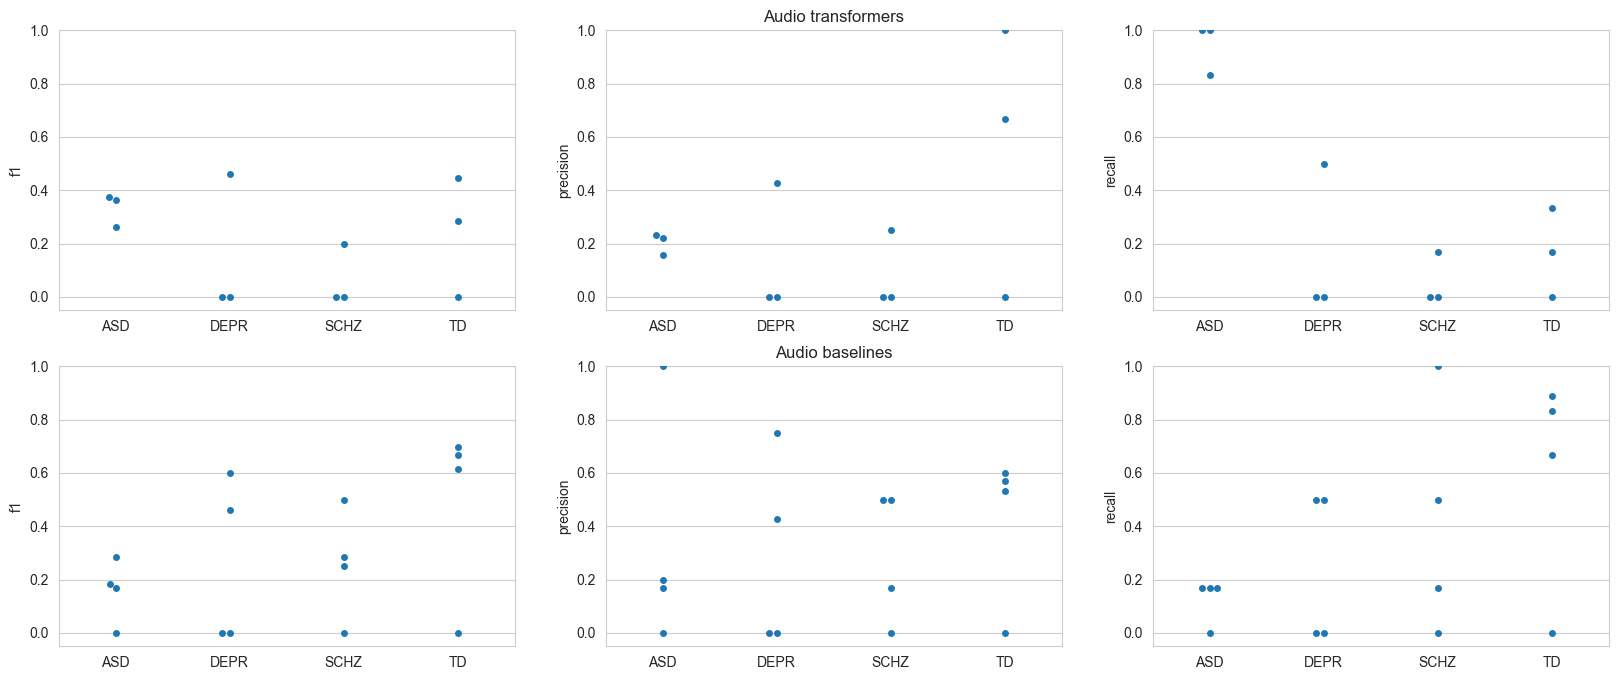

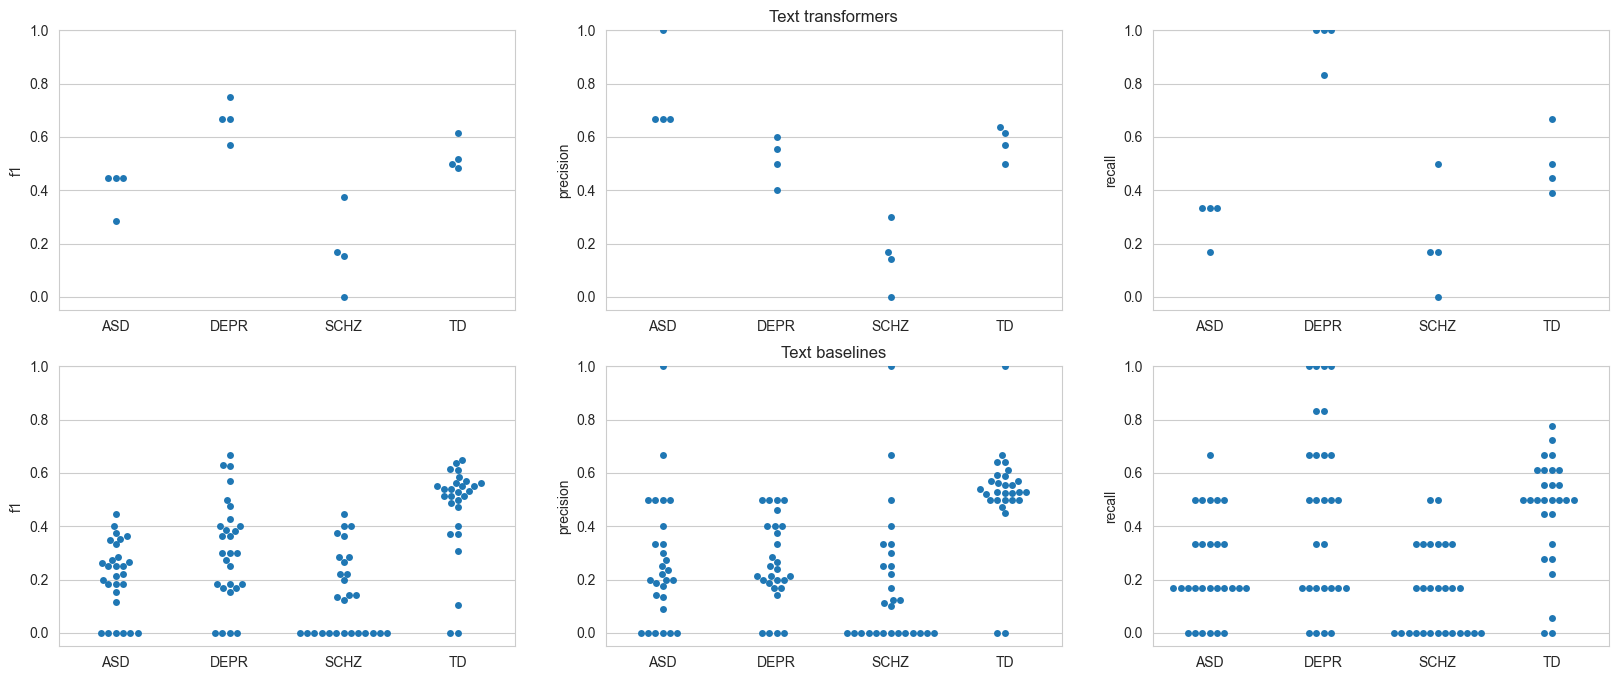

In [39]:
_swarmperf(audio, 'Audio')
_swarmperf(text, 'Text')

This tells us that overall, baselines seem to be better to classify depression. <br> 
Now, it would be interesting to figure out whether model performance is balanced across the three categories, or whether some models do better on one vs. the other category. Let's find out.

In [40]:
def _get_best(data, tclass):
    best_mod = data[(data['target_class']=='multiclass') & \
                     (data['class']==tclass) & \
                     (data['score_type']=='f1') & \
                     (data['split']=='test') & 
                     (data['level']=='id')]
    return best_mod.sort_values(by='value', ascending=False).head(n=10).model_name.tolist()[:5]

In [41]:
audio_asd = _get_best(audio, 'ASD')
audio_depr = _get_best(audio, 'DEPR')
audio_schz = _get_best(audio, 'SCHZ')
text_asd = _get_best(text, 'ASD')
text_depr = _get_best(text, 'DEPR')
text_schz = _get_best(text, 'SCHZ')
audio['is_best_asd'] = np.where(audio['model_name'].isin(audio_asd), 1, 0)
audio['is_best_depr'] = np.where(audio['model_name'].isin(audio_depr), 1, 0)
audio['is_best_schz'] = np.where(audio['model_name'].isin(audio_schz), 1, 0)
text['is_best_asd'] = np.where(text['model_name'].isin(text_asd), 1, 0)
text['is_best_depr'] = np.where(text['model_name'].isin(text_depr), 1, 0)
text['is_best_schz'] = np.where(text['model_name'].isin(text_schz), 1, 0)



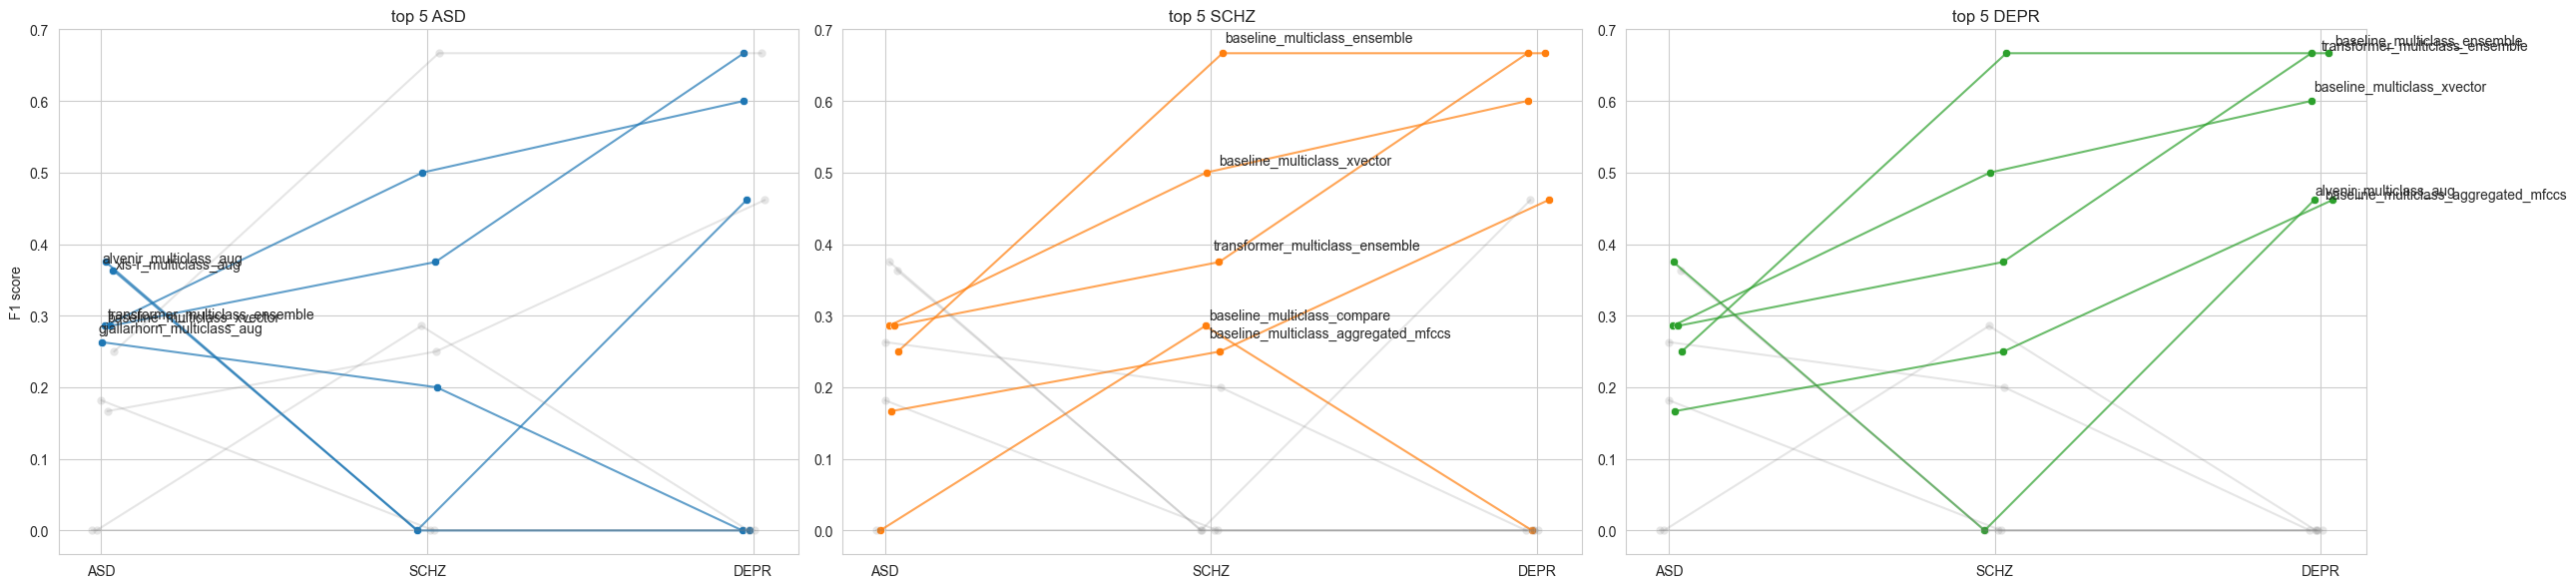

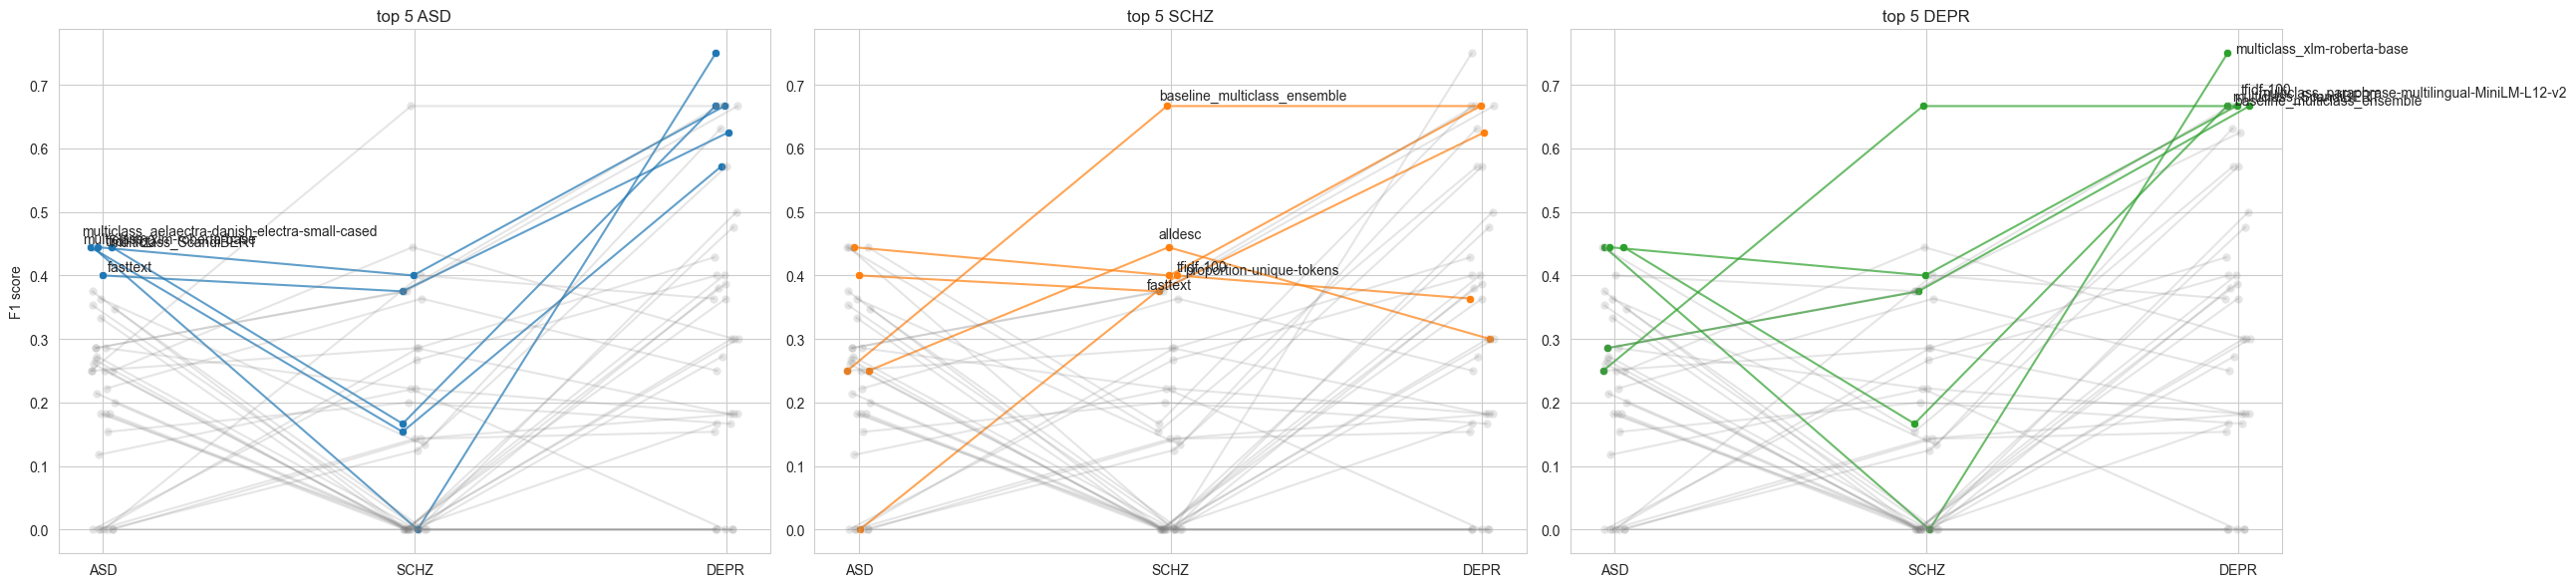

In [42]:
for data in [audio, text]:
    df_long = data[(data['target_class']=='multiclass') & \
                   (data['class']!='overall') & \
                   (data['score_type']=='f1') & \
                   (data['split']=='test') & 
                   (data['level']=='id')]
    jitter = np.random.uniform(-.04,.04,df_long.shape[0])
    df_long['model_name'] = df_long.model_name.apply(lambda x: x.split(r'_lr')[0])
    df_long['variable_n'] = df_long['class'].replace(dict(zip(['ASD',
                                                                'SCHZ',
                                                                'DEPR',
                                                                'TD'], 
                                                               range(4)))) + jitter
    df_long['value'] = df_long['value'].astype(float)
    df_long = df_long[df_long['class']!='TD']
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(26,6))
    for i, m in enumerate(['asd', 'schz', 'depr']):
        # Plot lines for best
        sns.lineplot(data=df_long[df_long[f'is_best_{m}']==1], 
                     x='variable_n', 
                     y='value', 
                     hue='model_name', 
                     alpha=.7, 
                     palette=[sns.color_palette()[i]]*5,
                     legend=False, 
                     ax=ax[i])
        sns.lineplot(data=df_long[df_long[f'is_best_{m}']==0], 
                     x='variable_n', 
                     y='value', 
                     hue='model_name', 
                     alpha=.2, 
                     palette=['grey'] * int(df_long.model_name.nunique()-5),
                     legend=False, 
                     ax=ax[i])
        # Same deal with points
        sns.scatterplot(data=df_long[df_long[f'is_best_{m}']==1], 
                        x='variable_n', 
                        y='value', 
                        color=sns.color_palette()[i], 
                        ax=ax[i])
        sns.scatterplot(data=df_long[df_long[f'is_best_{m}']==0], 
                        x='variable_n', 
                        y='value', 
                        color='grey', 
                        alpha=.2, 
                        ax=ax[i])
        ax[i].set_xticks(ticks=[0,1,2])
        ax[i].set_xticklabels(labels=['ASD', 'SCHZ', 'DEPR'])
        ax[i].set_xlabel('')
        # Add the annotations
        if i != 0:
            ax[i].set_ylabel('')
        else:
            ax[i].set_ylabel('F1 score')
        ax[i].set_title(f'top 5 {m.upper()}')
        for aix in range(df_long[df_long['variable_n'].round()==i].shape[0]):
            if df_long[df_long['variable_n'].round()==i][f'is_best_{m}'].tolist()[aix] == True:
                ax[i].text(x=df_long[df_long['variable_n'].round()==i]['variable_n'].tolist()[aix] + np.random.uniform(-.04, .04, 1), 
                           y=df_long[df_long['variable_n'].round()==i]['value'].tolist()[aix] + np.random.uniform(0, .02, 1),
                           s=df_long[df_long['variable_n'].round()==i]['model_name'].tolist()[aix])
    plt.tight_layout()
    plt.show()

## Plot top 5 model performance for each target class


In [43]:
def _get_best_overall(data, tclass, n):
    best_mod = data[(data['target_class']==tclass) & \
                     (data['class']=="overall") & \
                     (data['score_type']=='f1_macro') & \
                     (data['split']=='test') & 
                     (data['level']=='id')]
    best_models = best_mod.sort_values(by='value', ascending=False).model_name.tolist()

    i = 0
    while True:
        best_mods = best_models[:n+i]
        if len(set(best_mods)) == n:
            return best_mods
        i += 1


def _plot_best(data, metric, level, figsize, target_class):
    fig, ax = plt.subplots(figsize=figsize)
    if target_class == 'multiclass':
            df = data[(data['score_type'] == metric) & \
                      (data['level']==level) & \
                      (data['binary']==0) & \
                      (data["target_class"] == target_class) & \
                       (data[f"is_best_{target_class}"] == 1)
                     ]
    else:
        df = data[(data['score_type'] == metric) & \
                  (data['level']==level) & \
                  (data['binary']==1) &
                  (data['target_class']==target_class) & \
                   (data[f"is_best_{target_class}"] == 1)   ]
    df['model_name'] = df.model_name.apply(lambda x: x.split(r'_lr')[0])
    df['model_name'] = np.where(df['is_baseline']==1 & ~df['model_name'].str.contains('baseline_'), 
                                'baseline_' + df['model_name'], 
                                df['model_name'])
    df = df.sort_values(by=['split', 'value'])
    sns.scatterplot(data=df, y='model_name', x='value', hue='split', 
                    palette=['grey', sns.color_palette()[1], sns.color_palette()[3]], 
                    hue_order=['train', 'val', 'test'], marker='s', ax=ax)
    plt.legend(title=None)
    plt.title(f'{target_class}')
    sns.lineplot(data=df,  
                 x='value', y='model_name', hue='model_name',
                 legend=False, 
                 palette=['grey']*df.model_name.nunique(), 
                 alpha=.4, ax=ax)
    # color labels by baseline or transformer
    label_cols = ["grey" if "baseline" in model_n else "sienna" for model_n in df["model_name"].unique()]
    # add color for ensemble
    label_cols = ["steelblue" if "ensemble" in model_n else label_cols[i] for i, model_n in enumerate(df["model_name"].unique())]

    [t.set_color(label_cols[i]) for i, t in enumerate(ax.yaxis.get_ticklabels())]
    plt.xlim(0,1)
    plt.xlabel(f'{metric}')
    plt.ylabel('')
    plt.savefig(f"../figs/best_{metric}_{target_class}.png", bbox_inches="tight", dpi=300)
    plt.show()


from pandas.io.formats.style import Styler
from typing import List

def _best_table(data, metrics: List[str], level: str, target_class: str):
    if target_class == 'multiclass':
            df = data[(data['score_type'].isin(metrics)) & \
                      (data['level']==level) & \
                      (data['binary']==0) & \
                      (data["target_class"] == target_class) & \
                       (data[f"is_best_{target_class}"] == 1)
                     ]
    else:
        df = data[(data['score_type'].isin(metrics)) & \
                  (data['level']==level) & \
                  (data['binary']==1) &
                  (data['target_class']==target_class) & \
                   (data[f"is_best_{target_class}"] == 1)   ]
    df['model_name'] = df.model_name.apply(lambda x: x.split(r'_lr')[0])
    df['model_name'] = np.where(df['is_baseline']==1 & ~df['model_name'].str.contains('baseline_'), 
                                'baseline_' + df['model_name'], 
                                df['model_name'])
    df = df.sort_values(by=['split', 'value'])

    df = df.drop_duplicates(subset=["model_name", "split", "score_type"])

    if len(metrics) > 1:
        df = df[["model_name", "split", "value", "score_type"]]\
            .pivot(index=["model_name"], columns=["split", "score_type"], values="value")
    else: 
        df = df[["model_name", "split", "value", "score_type"]]\
            .pivot(index=["model_name", "score_type"], columns=["split"], values="value")
    df = df[["train", "val", "test"]]
    if len(metrics) == 1:
        df = df.sort_values("test")
    else:
        df = df.sort_index(axis=1, level=[0,1])[["train", "val", "test"]]
        df = df.sort_values(by=("test", "f1_macro"))
    s = Styler(df, precision=2, escape="latex").to_latex(hrules=True, multicol_align="c", multirow_align="c")
    print(s)
    

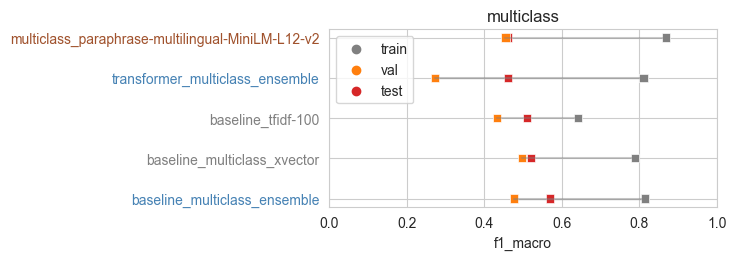

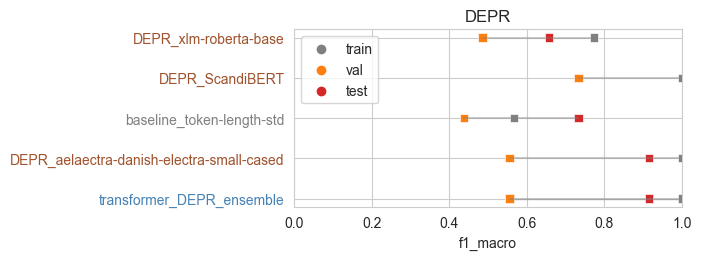

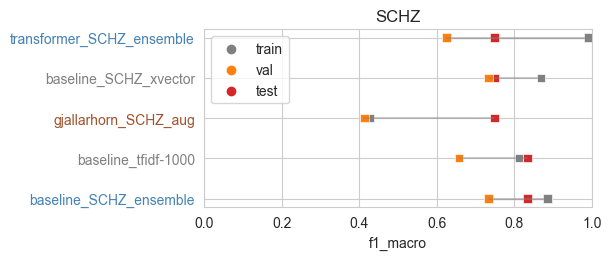

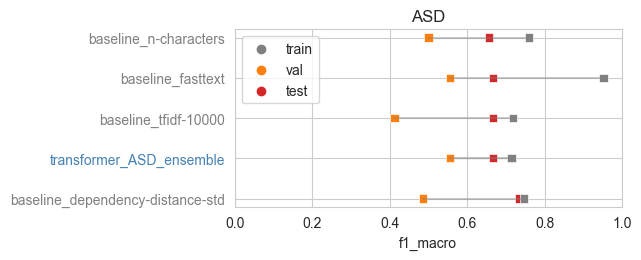

In [44]:

combined = pd.concat([text, audio], ignore_index=True)

for tclass in ["multiclass", "DEPR", "SCHZ", "ASD"]:
    best_model_name = _get_best_overall(combined, tclass, 5)
    combined[f"is_best_{tclass}"] = np.where(combined['model_name'].isin(best_model_name), 1, 0)
    _plot_best(combined, "f1_macro", "id", (5,2.3), tclass)



### Latex table

In [45]:
for tclass in ["DEPR", "SCHZ", "ASD"]:
    best_model_name = _get_best_overall(combined, tclass, 5)
    combined[f"is_best_{tclass}"] = np.where(combined['model_name'].isin(best_model_name), 1, 0)
    print(f"{tclass}")
    _best_table(combined, ["f1_macro", "auc"], "id", tclass)
    

tclass = "multiclass"
best_model_name = _get_best_overall(combined, tclass, 5)
combined[f"is_best_{tclass}"] = np.where(combined['model_name'].isin(best_model_name), 1, 0)
print(f"{tclass}")
_best_table(combined, ["f1_macro"], "id", tclass)

DEPR
\begin{tabular}{lllllll}
\toprule
split & \multicolumn{2}{c}{train} & \multicolumn{2}{c}{val} & \multicolumn{2}{c}{test} \\
score_type & auc & f1_macro & auc & f1_macro & auc & f1_macro \\
model_name &  &  &  &  &  &  \\
\midrule
DEPR_xlm-roberta-base & nan & 0.77 & nan & 0.49 & nan & 0.66 \\
DEPR_ScandiBERT & nan & 1.00 & nan & 0.73 & nan & 0.73 \\
baseline_token-length-std & nan & 0.57 & nan & 0.44 & nan & 0.73 \\
DEPR_aelaectra-danish-electra-small-cased & nan & 1.00 & nan & 0.56 & nan & 0.92 \\
transformer_DEPR_ensemble & 1.00 & 1.00 & 0.75 & 0.56 & 0.92 & 0.92 \\
\bottomrule
\end{tabular}

SCHZ
\begin{tabular}{lllllll}
\toprule
split & \multicolumn{2}{c}{train} & \multicolumn{2}{c}{val} & \multicolumn{2}{c}{test} \\
score_type & auc & f1_macro & auc & f1_macro & auc & f1_macro \\
model_name &  &  &  &  &  &  \\
\midrule
baseline_SCHZ_xvector & 0.94 & 0.87 & 0.86 & 0.73 & 0.83 & 0.75 \\
gjallarhorn_SCHZ_aug & 0.49 & 0.43 & 0.44 & 0.41 & 0.78 & 0.75 \\
transformer_SCHZ_ensemble